# ABL with MMC forcing

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

from scipy.optimize import root_scalar
from functools import partial

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    return np.abs(a - a0).argmin()

# Merging profiles
def tanhblend(x, x0, w):
    return 0.5*(1+np.tanh((x-x0)/w))

def tanhblendprofiles(profa, profb, x, x0, w):
    tanha = profa*(1-tanhblend(x, x0, w))
    tanhb = profb*(tanhblend(x, x0, w))
    return tanha + tanhb

def interpprofile(newz, z, prof):
    spl = CubicSpline(z, prof)
    interpprof = spl(newz)
    return interpprof
    #return np.interp(newz, z, prof)
    
def blendprofiles(newz, zA, profA, Bconst, x0, w):
    newprofA = interpprofile(newz, zA, profA)
    newprofB = Bconst*np.ones(len(newz)) #interpprofile(newz, zB, profB)
    return tanhblendprofiles(newprofA, newprofB, newz, x0, w)

In [3]:

def windrampfunction(t, t1, t2, wd1, wd2):
    """
    Define a wind ramp function
    """
    wdvec    = np.ones(len(t))*wd1
    tafter   = (t>t2)
    tbetween   = ((t[:] >= t1) & (t[:] <= t2))
    wdbetween = (wd2-wd1)/(t2-t1)*(t-t1) + wd1
    
    wdvec[tbetween] = wdbetween[tbetween]
    wdvec[tafter] = wd2
    return wdvec

In [4]:
tstart = 0
tend   = 360.0

# Define the wind speed profiles
tvec  = np.linspace(tstart, tend, 361)
wdvec = windrampfunction(tvec, 60, 120, 270, 225)

zvec  = np.linspace(0, 1000, 101)
WSconst = 9.0
TempConst = 300

Nt = len(tvec)
Nz = len(zvec)
fullWS = np.ones((Nt, Nz))*WSconst
fullWD = np.zeros((Nt, Nz))
fullT  = np.ones((Nt, Nz))*TempConst

for i in range(Nt):
    fullWD[i,:] = wdvec[i]*np.ones(Nz)

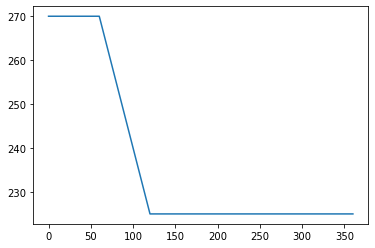

In [5]:
plt.plot(tvec, wdvec)

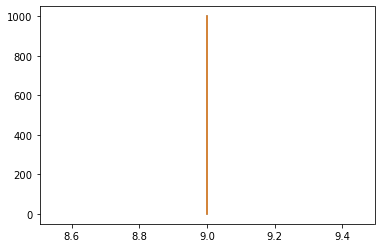

In [6]:
plt.plot(fullWS[0,:], zvec)
plt.plot(fullWS[-1,:], zvec)

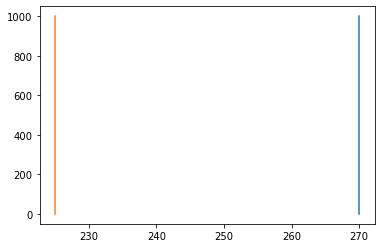

In [7]:
plt.plot(fullWD[0,:], zvec)
plt.plot(fullWD[-1,:], zvec)

In [8]:
# Convert from WS to WD
all_U = []
all_V = []

for i, t in enumerate(tvec):
    theta = (270.0 - fullWD[i,:])*np.pi/180.0
    WS    = fullWS[i,:]
    U     = WS*np.cos(theta)
    V     = WS*np.sin(theta)
    all_U.append(U)
    all_V.append(V)

all_U = np.array(all_U)
all_V = np.array(all_V)
all_T = fullT

fluxdat = 0.0*tvec

## Set up the case 

In [9]:
suffix      = '01'
rundir      = 'wdirtest_'+suffix
ICfilename  = 'init.nc'
MMCfilename = 'MMC.nc'
amrfilename = 'abl_MMC.inp'
rho         = 1.225

# Go to the run directory
if not os.path.exists(rundir):
    os.makedirs(rundir)

In [10]:
# Save the data to text files
np.savetxt(rundir+'/MMC_Ublend%s.dat'%suffix, all_U)
np.savetxt(rundir+'/MMC_Vblend%s.dat'%suffix, all_V)
np.savetxt(rundir+'/MMC_Tblend%s.dat'%suffix, all_T)
np.savetxt(rundir+'/MMC_all_heights.dat',     zvec)
np.savetxt(rundir+'/MMC_time_sec.dat',        tvec)

## Set up AMR-Wind case

In [11]:
# Start the case
case = amrwind.MyApp.init_nogui()

In [12]:
# Set the time constants
case.setAMRWindInput('time.stop_time', 360.0)
case.setAMRWindInput('time.max_step',  -1)

case.setAMRWindInput('time.fixed_dt',  0.50)
case.setAMRWindInput('time.checkpoint_interval',  10000)

In [13]:
# Set some basic parameters
case.setAMRWindInput('incflo.physics',      ['ABL'])  # Must have ABL physics to do ABL calculations
case.setAMRWindInput('incflo.verbose',      3)        # This is optional, verbose=3 means more info in the output logs
case.setAMRWindInput('io.check_file',       'chk')    # What to name the checkpoint files

case.setAMRWindInput('incflo.use_godunov',  True)       # Always use a godunov scheme
case.setAMRWindInput('incflo.godunov_type', 'weno_z')   # Use 'weno_z' 

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])    # One equation k-sgs subgrid scale model
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])      # The corresponding source term

case.setAMRWindInput('transport.viscosity', 1.771e-05)           # dynamic viscosity, based on median air temperature of 284.47 K from 2 m above E06, units Pa-s
case.setAMRWindInput('incflo.density',      rho)                 # density, based on 1017.13*100./(284.47)/287.058 where 1017.13 is median air pressure from 2 m above E06 
                                                                 #   and 284.47 is median air temperature from 2 m above E06, units kg/
case.setAMRWindInput('incflo.velocity',      [0, 0, 0])

In [14]:
# To set up the sampling output
case.setAMRWindInput('time.plot_interval',        -1) 

In [15]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

case.setAMRWindInput('incflo.do_initial_proj', 0)
case.setAMRWindInput('incflo.initial_iterations', 0)

In [16]:
# Sets up the domain and level 0 mesh
case.setAMRWindInput('geometry.prob_lo', [-2560.0,-960.0, 0.0 ])
case.setAMRWindInput('geometry.prob_hi', [2560.0,  960.0, 960.0])   # each number must be divisible by 16
case.setAMRWindInput('amr.n_cell',       [256,     96,    48])

In [17]:
# This cell sets up boundary conditions
case.setAMRWindInput('is_periodicx', True)     # periodic in x
case.setAMRWindInput('is_periodicy', True)     # periodic in y
case.setAMRWindInput('is_periodicz', False)    # Enforce some boundary conditions in z

In [18]:
# Boundary conditions in z
case.setAMRWindInput('zlo.type',              'wall_model')          
case.setAMRWindInput('zlo.tke_type',          'zero_gradient')       
case.setAMRWindInput('zhi.type',              'slip_wall')           
case.setAMRWindInput('zhi.temperature_type',  'fixed_gradient')    

In [19]:
# Now set up ABL specific forces, parameters, etc.
case.setAMRWindInput('ICNS.source_terms',            ['BoussinesqBuoyancy','ABLMesoForcingMom','ABLMeanBoussinesq',])
case.setAMRWindInput('Temperature.source_terms',     ['ABLMesoForcingTemp',])

case.setAMRWindInput('ABL.stats_output_frequency',   1, forcechange=True)           # Output ABL stats every iteration            
case.setAMRWindInput('ABL.stats_output_format',   'netcdf', forcechange=True)       # Use netcdf output because that's how we postprocess

case.setAMRWindInput('ABLForcing.abl_forcing_height',   150)       # Hub height wind speed you want specify 
case.setAMRWindInput('ABL.kappa',                       0.4)      # Kolmogorov constant

case.setAMRWindInput('ABL.normal_direction',      2)              # vertical is in z
case.setAMRWindInput('ABL.surface_roughness_z0',  0.0001)           # Surface roughess, SOMETHING WE WILL PROBABLY WANT TO ITERATE ON
case.setAMRWindInput('ABL.reference_temperature', 300.0)        # Correspond to what was measured at ARM

case.setAMRWindInput('ABL.perturb_temperature',    False, forcechange=True)
case.setAMRWindInput('ABL.perturb_velocity',       False, forcechange=True)

# Monin-Obukhov parameters (No need to change)
case.setAMRWindInput('ABL.mo_beta_m',             16.0)
case.setAMRWindInput('ABL.mo_gamma_m',            5.0)
case.setAMRWindInput('ABL.mo_gamma_h',            5.0)
case.setAMRWindInput('ABL.random_gauss_mean',     0.0)
case.setAMRWindInput('ABL.random_gauss_var',      1.0)

case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 300.0)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


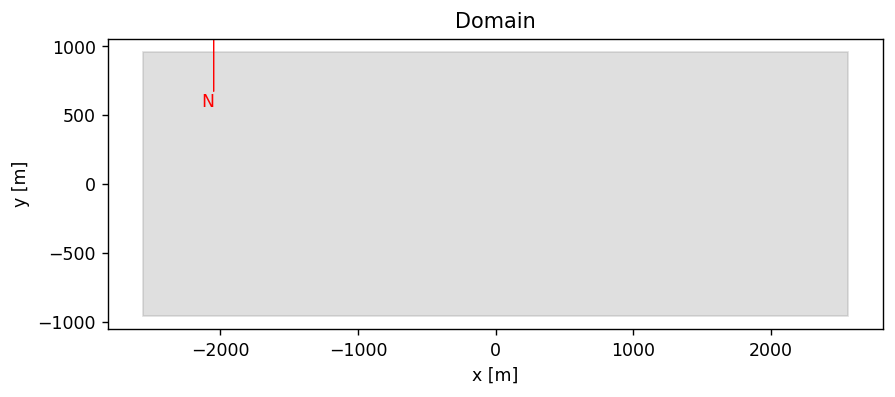

In [20]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

### Create sampling planes

In [21]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
hh,  hubheight,2560,2560,960, 0,  none,  11, 11, usedx:10 units:meter center:specified centerx:0.0 centery:0.0 centerz:90.0 orientation:x wholedomain:1
"""
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [22]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_hh']


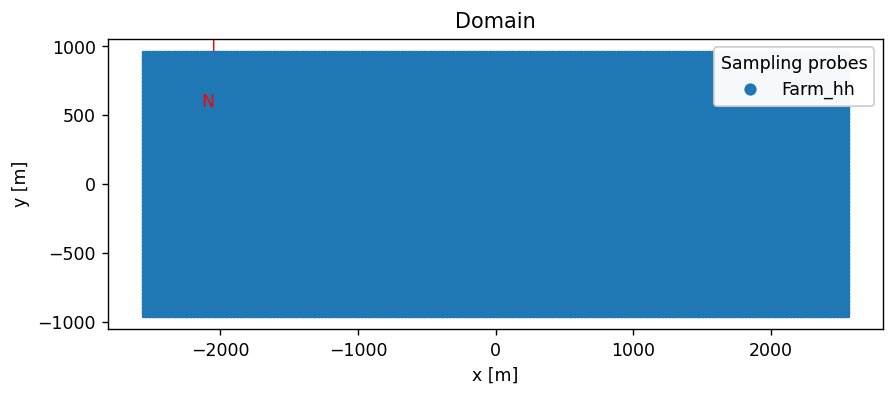

In [23]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

## MMC parameters

In [24]:
# Set the MMC inputs
zstr, Tstr = writeMMC.makeIC_fromMMC(case.getAMRWindInput('geometry.prob_lo'), 
                                     case.getAMRWindInput('geometry.prob_hi'), 
                                     case.getAMRWindInput('amr.n_cell'), 
                                     all_U, all_V, all_T,
                                     tvec, zvec, rundir+'/'+ICfilename, tstart, verbose=True)
writeMMC.makeMMCforcing(case.getAMRWindInput('geometry.prob_lo'), 
                        case.getAMRWindInput('geometry.prob_hi'), 
                        case.getAMRWindInput('amr.n_cell'), 
                        all_U, all_V, all_T, fluxdat,
                        tvec, zvec, rundir+'/'+MMCfilename)

# These inputs set up the initial temperature profile (Same as Nalu-Wind temperature profile)
case.setAMRWindInput('ABL.temperature_heights', zstr)
case.setAMRWindInput('ABL.temperature_values',  Tstr)

# MMC files
case.setAMRWindInput('ABL.initial_condition_input_file', ICfilename) # this is only for u,v
case.setAMRWindInput('ABL.mesoscale_forcing', MMCfilename)

case.setAMRWindInput('ABLMesoForcingMom.forcing_scheme', "direct")
case.setAMRWindInput('ABLMesoForcingTemp.forcing_scheme', "direct")

#case.setAMRWindInput('ABLMesoForcingMom.forcing_transition',  "directToConstant")
#case.setAMRWindInput('ABLMesoForcingTemp.forcing_transition', "directToConstant")
#case.setAMRWindInput('ABLMesoForcingMom.constant_transition_height',  450.0)
#case.setAMRWindInput('ABLMesoForcingTemp.constant_transition_height', 450.0)
#case.setAMRWindInput('ABLMesoForcingMom.transition_thickness',  100.0)
#case.setAMRWindInput('ABLMesoForcingTemp.transition_thickness', 100.0)

[============================================================] 100.0% 
[============================================================] 100.0% 
[============================================================] 100.0% 
NETCDF4
Wrote heights and times
Wrote momentum profiles
Wrote temperature profiles
Wrote tflux profiles
Done


In [25]:
# UNCOMMENT THIS LATER
# Add boundary plane inputs
case.setAMRWindInput('ABL_useboundaryplane',        True)
case.setAMRWindInput('ABL.bndry_file',              'bndry_file')
case.setAMRWindInput('ABL.bndry_io_mode',           '0')
case.setAMRWindInput('ABL.bndry_planes',            ['xlo','ylo'])
case.setAMRWindInput('ABL.bndry_output_start_time', 0.0)
case.setAMRWindInput('ABL.bndry_var_names',         'velocity temperature tke')

In [26]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0      1179648             20.0 x 20.0 x 20.0
  TOTAL:      1179648


In [27]:
# Write the input file
print(case.writeAMRWindInput(rundir+'/'+amrfilename))

# --- Simulation time control parameters ---
time.stop_time                           = 360.0               # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.5                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol             